# Análisis de arquetipos inicial

Este notebook realiza un análisis de los arquetipos iniciales de la gran nube de Magallanes (LMC) y de la pequeña nube de Magallanes (SMC). Se utilizarán los datos de la tabla de datos del proyecto de tesis.
Este proceso será preliminar para entender el funcionamiento del algoritmo y sus aplicaciones.

In [1]:
# 1. Librerías
import os
import glob
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.interpolate import interp1d
from astropy.timeseries import LombScargle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
# 2. Utilidades - Leer .dat OGLE

def read_dat(filepath): 
  """
  Intenta leer columnas numéricas ignorando encabezados.
  Devuleve time, mag, err (err puede ser None)
  """
  # Leer ignorando líneas que no inicien con número
  data = []
  with open(filepath, "r", encoding='latin-1') as f:
    for line in f:
      s = line.strip()
      if not s:
        continue

      # Considerar líneas que comienzan con dígito o signo
      if s[0].isdigit() or s[0] in ('-', '+', '.'):
        parts = s.split()
        # Guardamos si tiene al menos 2 columnas
        if len(parts) >= 2:
          try:
            nums = [float(x) for x in parts[:3]] # Intento 3
            data.append(nums)
          except:
            continue

  data = np.array(data)
  if data.size == 0:
    raise ValueError(f"No numeric rows found in {filepath}")
  if data.shape[1] == 1:
    raise ValueError(f"Not enough columns in {filepath}")
  time = data[:,0]
  mag = data[:,1]
  err = data[:,2] if data.shape[1] > 2 else None
  return time, mag, err

In [3]:
# 3. Funciones de preprocesado y folding

def phase_fold(time, mag, period):
  phi = ((time / period)%1.0)
  sort_idx = np.argsort(phi)
  return phi[sort_idx], mag[sort_idx]

def bin_phase(phi, mag, nbins=100):
  bins = np.linspace(0,1,nbins+1)
  inds = np.digitize(phi, bins)-1
  bin_means = np.full(nbins, np.nan)
  for i in range(nbins):
    sel = inds==i
    if sel.any():
      bin_means[i] = np.mean(mag[sel])
  # Interpolar nan
  idx = np.arange(nbins)
  good = ~np.isnan(bin_means)
  f = interp1d(idx[good], bin_means[good], kind='linear', bounds_error=False, fill_value="extrapolate")
  return f(idx)

In [4]:
# 4. Ajuste armónico (Fourier) dado período; devuelve coeficientes (a0, a_k, b_k)
def fourier_fit(time, mag, period, nharm=4):
  # Fase [-pi. pi]
  t0 = time.min()
  x = 2*np.pi*(time-t0)/period
  # Build design
  cols = [np.ones_like(x)]
  for k in range(1, nharm+1):
    cols.append(np.cos(k*x))
    cols.append(np.sin(k*x))
  A = np.vstack(cols).T
  # Solve least squares
  coef, *_=np.linalg.lstsq(A, mag, rcond=None)
  return coef # lenght = 1 + 2*nharm

In [5]:
# 5. Proyección sobre simplex (Duchi et al.)
def project_simplex(v):
    """ Proyecta un vector v en el simplex {w: w>=0, sum(w)=1} """
    if v.size == 0:
        return np.array([1.0])  # o vector vacío de salida controlada
    v = np.asarray(v)
    n = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - 1))[0]
    if len(rho) == 0:
        return np.ones_like(v) / n
    rho = rho[-1]
    theta = (cssv[rho] - 1) / (rho + 1.0)
    w = np.maximum(v - theta, 0)
    return w

In [6]:
# 6. Implementación simple de AA (alternating)
def archetypal_analysis(X, K=3, max_iter=200, tol=1e-6, verbose=True):
    """
    X: N x M (N = observaciones, M = variables)
    K: número de arquetipos
    Returns: S (N x K), C (K x N), A (K x M)
    """

    N, M = X.shape
    rng = np.random.RandomState(0)
    idx = rng.choice(N, size=K, replace=False)
    A = X[idx,:].copy()  # arquetipos iniciales
    S = np.zeros((N,K))
    C = np.zeros((K,N))
    prev_rss = np.inf

    for it in range(max_iter):
        # --- actualizar S ---
        At = A.T  # M x K
        ATA = At.T @ At + 1e-8*np.eye(K)
        AT = At.T
        for n in range(N):
            xn = X[n,:]
            b = AT @ xn
            s_un = np.linalg.solve(ATA, b)
            S[n,:] = project_simplex(s_un)

        # --- actualizar A ---
        StS = S.T @ S + 1e-8*np.eye(K)
        A = np.linalg.solve(StS, S.T @ X)

        # --- actualizar C ---
        for k in range(K):
            ak = A[k, :]
            sol = np.linalg.lstsq(X.T, ak, rcond=None)[0]
            if sol.size == 0:
                sol = np.zeros(N)
            C[k,:] = project_simplex(sol)

        # recomputar A = C X
        A = C @ X

        # calcular RSS
        recon = S @ A
        rss = np.linalg.norm(X - recon, ord='fro')**2
        if verbose and it % 5 == 0:
            print(f"iter {it}, RSS={rss:.6e}")
        if abs(prev_rss - rss) < tol:
            if verbose:
                print(f"Converged iter {it}, RSS={rss:.6e}")
            break
        prev_rss = rss

    return S, C, A

In [7]:
# 7. Pipeline completo para un directorio de .dat
input_dir = "BD/OGLEIV/RR_Lyrae/limpios/prueba"
min_obs = 300
period_catalog = {}

star_paths = sorted(glob.glob(os.path.join(input_dir, "*.dat")))
print(f"Found {len(star_paths)} .dat files")

# Listas para featuries y ids
X_list = []
ids = []
for fp in star_paths:
  try:
    time, mag, err = read_dat(fp)
  except Exception as e:
    print("Skipping", fp, ":", e)
    continue
  if len(time) < min_obs:
    continue
  # Optional: get period from catalog; else compute with Lomb-Scargle
  # Heurística: si el filename contiene period, intenta extraerlo
  star_id = os.path.basename(fp).split('.')[0]
  period = period_catalog.get(star_id, None)
  if period is None:
    # compute period with Lomb-Scargle over plausible RR Lyrae range (0.2 - 1.0 days typical)
    freq, power = LombScargle(time, mag).autopower(minimum_frequency=1/3.0, maximum_frequency=5)
    bestf = freq[np.argmax(power)]
    period = 1.0/bestf
  # Elección: Fourier features (recomendado)
  coef = fourier_fit(time, mag, period, nharm=4) # yields 1 + 2*4 = 9 features
  feat = coef.flatten()
  X_list.append(feat)
  ids.append(star_id)

X = np.vstack(X_list)
print("Feature matrix X shape:", X.shape)

Found 100 .dat files
Feature matrix X shape: (46, 9)


In [8]:
# 8. Procesado y PCA
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA(n_components=min(20, Xs.shape[1]))
Xred = pca.fit_transform(Xs)
print("Reduced X shape:", Xred.shape)

Reduced X shape: (46, 9)


In [9]:
# 9. Ejecutar AA
K = 4 # número de arquetipos que quieres probar
S, C, A = archetypal_analysis(Xred, K=K, max_iter=200, verbose=True)
print("S shape", S.shape, "A shape", A.shape)

iter 0, RSS=2.766124e+02
iter 5, RSS=3.344445e+02
iter 10, RSS=2.748465e+02
iter 15, RSS=3.313811e+02
iter 20, RSS=3.133795e+02
iter 25, RSS=3.226625e+02
iter 30, RSS=3.183131e+02
iter 35, RSS=3.206192e+02
iter 40, RSS=3.195095e+02
iter 45, RSS=3.200646e+02
iter 50, RSS=3.197902e+02
iter 55, RSS=3.199282e+02
iter 60, RSS=3.198591e+02
iter 65, RSS=3.198938e+02
iter 70, RSS=3.198764e+02
iter 75, RSS=3.198851e+02
iter 80, RSS=3.198807e+02
iter 85, RSS=3.198829e+02
iter 90, RSS=3.198818e+02
iter 95, RSS=3.198824e+02
iter 100, RSS=3.198821e+02
iter 105, RSS=3.198822e+02
iter 110, RSS=3.198822e+02
iter 115, RSS=3.198822e+02
iter 120, RSS=3.198822e+02
iter 125, RSS=3.198822e+02
iter 130, RSS=3.198822e+02
iter 135, RSS=3.198822e+02
Converged iter 139, RSS=3.198822e+02
S shape (46, 4) A shape (4, 9)


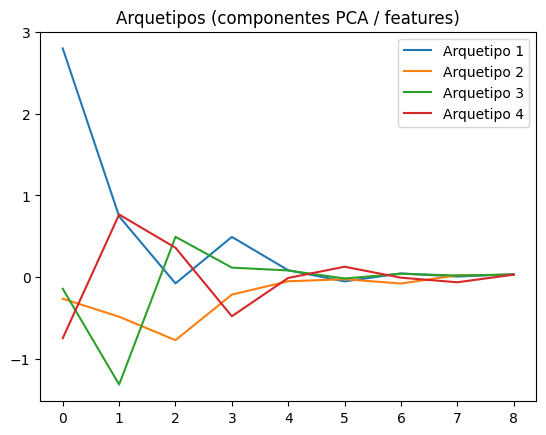

In [10]:
# 10: visualizar arquetipos (en espacio de features)
# Si usaste PCA, los arquetipos A están en espacio PCA (K x ncomp). 
# Para ver perfiles de curva si usaste binning, reconstruye y grafica
for k in range(K):
  plt.plot(A[k,:], label=f"Arquetipo {k+1}")
plt.legend(); plt.title("Arquetipos (componentes PCA / features)"); plt.show()